In [1]:
import pandas as pd
df = pd.read_csv('Drug_Train.csv')
df.head(8)


,Drug Name,Review,Rating,Unnamed: 3
0,Valsartan,"""It has no side effect, I take it in combinati...",9,NaN
1,Guanfacine,"""My son is halfway through his fourth week of ...",8,NaN
2,Lybrel,"""I used to take another oral contraceptive, wh...",5,NaN
3,Ortho Evra,"""This is my first time using any form of birth...",8,NaN
4,Buprenorphine / naloxone,"""Suboxone has completely turned my life around...",9,NaN
5,Cialis,"""2nd day on 5mg started to work with rock hard...",2,NaN
6,Levonorgestrel,"""He pulled out, but he cummed a bit in me. I t...",1,NaN
7,Aripiprazole,"""Abilify changed my life. There is hope. I was...",10,NaN


In [3]:
from io import StringIO

col = ['Review','Rating']
df = df[col]
df = df[pd.notnull(df['Review'])] 

df.columns = ['Review','Rating']

df['category_id'] = df['Rating'].factorize()[0]
category_id_df = df[['Rating', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Rating']].values)
df.head()



,Review,Rating,category_id
0,"""It has no side effect, I take it in combinati...",9,0
1,"""My son is halfway through his fourth week of ...",8,1
2,"""I used to take another oral contraceptive, wh...",5,2
3,"""This is my first time using any form of birth...",8,1
4,"""Suboxone has completely turned my life around...",9,0


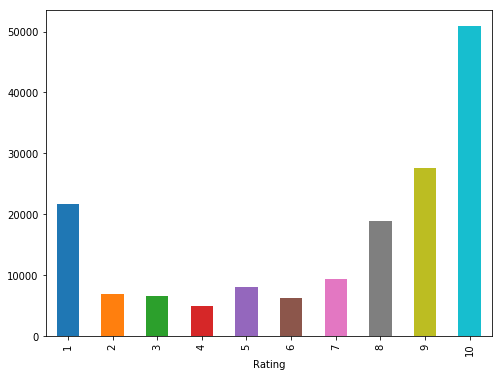

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Rating').Review.count().plot.bar(ylim=0)
plt.show()

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Review)
labels = df.category_id
features.shape

(161297, 197773)

In [6]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Rating, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  #print("# '{}':".format(Rating))
  #print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  #print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'],test_size=0.3, random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = LinearSVC().fit(X_train_tfidf, y_train)

In [13]:
y_pred = clf.predict(count_vect.transform(X_test))
#Check predictions on 5 random samples
print(y_pred[130:135])
print(y_test[130:135])

[ 9  9 10  5 10]
15156     8
127218    9
71702     9
71715     5
48604     9
Name: Rating, dtype: int64


In [14]:
from sklearn.metrics import accuracy_score
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.4110560033064683
